# Running FEISTY with time-series forcing from CESM

Kristen produced a 1 degree companion run to our high-res run on frontera, and then converted output to time series.
This notebook doesn't really need to be a notebook, I'm hoping it can be converted to a script instead.
All the parameter settings are handled in the first (non-`import`) cell, where we read in `feisty-config.TL319_g17.4p2z.001.yml`.
This was run on a casper login node with 4 GB of memory, but all data is kept distributed on the dask cluster.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import dask
import matplotlib.pyplot as plt
import nc_time_axis  # needed for time series plot for some reason
import numpy as np
import xarray as xr
import yaml
from dask.distributed import Client
from dask_jobqueue import PBSCluster

import feisty

## Configure run

The FEISTY command `config_and_run_from_yaml()` needs a dictionary pointing to forcing streams and initial conditions.
We provide a few `YAML` files containing acceptable configurations.
There are also several parameters controlling how the run is set up.

In [3]:
# Read settings from YAML
feisty_config_file = 'feisty-config.TL319_g17.4p2z.001.yml'
with open(feisty_config_file) as f:
    feisty_config = yaml.safe_load(f)

outdir = os.path.join(os.path.sep, 'glade', 'derecho', 'scratch', os.environ['USER'], 'feisty_output')

## Set up Dask cluster

Since the data in `ds` is chunked in (`nlat`, `nlon`), we use a `dask` cluster to configure the parallelization

In [4]:
mem = 20  # GB
dask.config.set({'distributed.dashboard.link': 'proxy/{port}/status'})
# dask.config.set({"distributed.comm.timeouts.tcp": "180s"})
# dask.config.set({"distributed.comm.timeouts.connect": "180s"})
cluster = PBSCluster(
    memory=f'{mem} GB',
    processes=1,
    cores=1,
    queue='casper',
    walltime='1:00:00',
    resource_spec=f'select=1:ncpus=1:mem={mem}GB',
    log_directory='./dask-logs',
)

cluster.scale(feisty_config['num_workers'])
client = Client(cluster)
client

/glade/work/mlevy/miniconda3/envs/dev-feisty/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43225 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: proxy/43225/status,
Dashboard: proxy/43225/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.49:38428,Workers: 0
Dashboard: proxy/43225/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
%%time

client.wait_for_workers(feisty_config['num_workers'])

CPU times: user 260 ms, sys: 31.8 ms, total: 291 ms
Wall time: 14.1 s


## Run the model

In [6]:
%%time

start_year = 1980
end_year = 1984
nyears = end_year - start_year + 1
output_suffix = 'zarr'

ds_list = list()
for year in range(start_year, start_year + nyears):
    print(f'Configuring FEISTY for {year}...')

    # Start and End dates
    feisty_config['start_date'] = f'{year}-01-01'
    feisty_config['end_date'] = f'{year}-12-31'

    # Initialize from restart (unless this is first year)
    previous_restart = f'companion.{year-1}-12-31.{output_suffix}'
    if os.path.exists(os.path.join(outdir, 'rest', previous_restart)):
        print(f'Restarting from {previous_restart}')
        feisty_config['initial_conditions'] = {
            'root_dir': os.path.join(outdir, 'rest'),
            'ic_file': previous_restart,
        }

    # Set up history and restart files for output
    feisty_config['output']['hist_dir'] = os.path.join(outdir, 'hist')
    feisty_config['output']['hist_file'] = f'companion.{year}.{output_suffix}'
    feisty_config['output']['rest_dir'] = os.path.join(outdir, 'rest')
    feisty_config['output']['rest_file'] = f'companion.{year}-12-31.{output_suffix}'

    # map_blocks lets us run in parallel over our dask cluster
    print(f'Running FEISTY for year {year}...')
    ds_list.append(feisty.config_and_run_from_yaml(feisty_config))

ds_out = xr.concat(ds_list, dim='time')
ds_out["biomass"]

Configuring FEISTY for 1980...
Running FEISTY for year 1980...
Starting template generation at 10:50:40


/glade/work/mlevy/miniconda3/envs/dev-feisty/lib/python3.11/site-packages/distributed/worker.py:2988: UserWarning: Large object of size 1.29 MiB detected in task graph: 
  ([('forcing_time',), <xarray.IndexVariable 'forcin ... =object), {}],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


Writing /glade/scratch/mlevy/feisty_output/hist/companion.1980.zarr
Calling to_zarr...
Starting with biomass
Writing fish_yield to disk
Writing production to disk
Writing /glade/scratch/mlevy/feisty_output/rest/companion.1980-12-31.zarr
Calling to_zarr...
Configuring FEISTY for 1981...
Restarting from companion.1980-12-31.zarr
Running FEISTY for year 1981...
Starting template generation at 10:53:17
Writing /glade/scratch/mlevy/feisty_output/hist/companion.1981.zarr
Calling to_zarr...
Starting with biomass
Writing fish_yield to disk
Writing production to disk
Writing /glade/scratch/mlevy/feisty_output/rest/companion.1981-12-31.zarr
Calling to_zarr...
Configuring FEISTY for 1982...
Restarting from companion.1981-12-31.zarr
Running FEISTY for year 1982...
Starting template generation at 10:55:32
Writing /glade/scratch/mlevy/feisty_output/hist/companion.1982.zarr
Calling to_zarr...
Starting with biomass
Writing fish_yield to disk
Writing production to disk
Writing /glade/scratch/mlevy/feis

<xarray.DataArray 'biomass' (time: 1825, group: 9, nlat: 384, nlon: 320)>
dask.array<concatenate, shape=(1825, 9, 384, 320), dtype=float64, chunksize=(365, 9, 128, 80), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1980-01-01 00:00:00 ... 1984-12-31 00:00:00
  * group    (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 8 ... 376 377 378 379 380 381 382 383
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319

### Plotting

Make a plot of `biomass` over time at a specified column,
then do the same for `fish_yield`

CPU times: user 230 ms, sys: 7.86 ms, total: 238 ms
Wall time: 305 ms


Text(0.5, 0.98, 'biomass at (215, 233)')

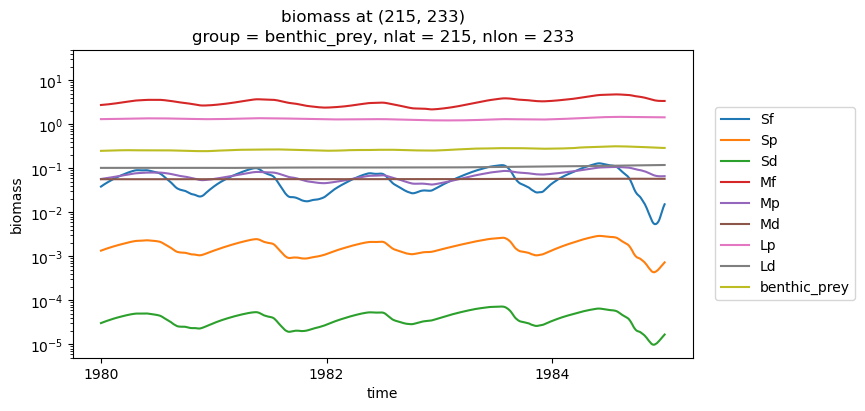

In [7]:
%%time

# Select column for time series plot
nlat = 215
nlon = 233

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
for group in ds_out.group.data:
    ds_out['biomass'].isel(nlat=nlat, nlon=nlon).sel(group=group).plot()
ax.set_ylim([5e-6, 50])
ax.set_yscale("log")
plt.legend(ds_out.group.data, bbox_to_anchor=(1.025, 0.5), loc=6)
fig.suptitle(f"biomass at ({nlat}, {nlon})");

CPU times: user 196 ms, sys: 7.94 ms, total: 204 ms
Wall time: 268 ms


Text(0.5, 0.98, 'Fish yield at (215, 233)')

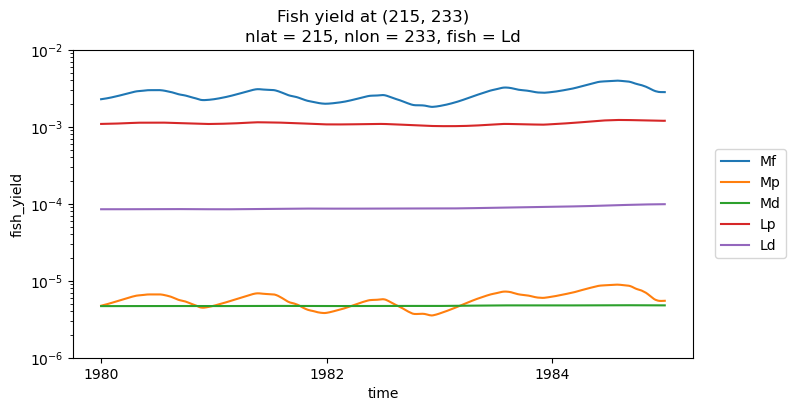

In [8]:
%%time

# Select column for time series plot
nlat = 215
nlon = 233

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plotted_fish = []
for fish in ds_out.fish.data:
    if np.nanmax(ds_out['fish_yield'].isel(nlat=nlat, nlon=nlon).sel(fish=fish).values) <= 0:
        continue
    plotted_fish.append(fish)
    ds_out['fish_yield'].isel(nlat=nlat, nlon=nlon).sel(fish=fish).plot()
ax.set_ylim([1e-6, 1e-2])
ax.set_yscale("log")
plt.legend(plotted_fish, bbox_to_anchor=(1.025, 0.5), loc=6)
fig.suptitle(f"Fish yield at ({nlat}, {nlon})");

CPU times: user 61.7 ms, sys: 3.05 ms, total: 64.8 ms
Wall time: 67.5 ms


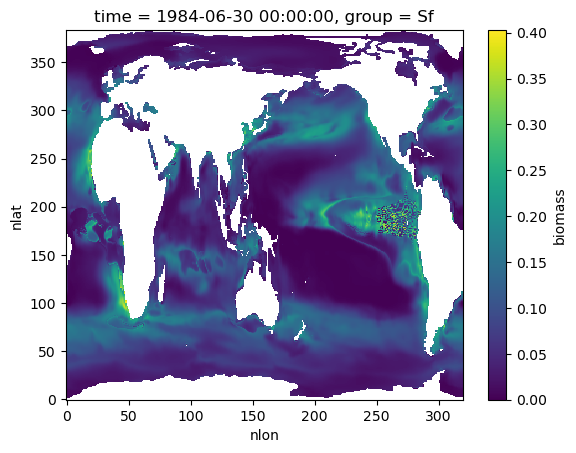

In [9]:
%%time

ds_out["biomass"].isel(time=(nyears - 1) * 365 + 180, group=0).plot()